#Prepare Environment

In [1]:
DIRPATH_SDS = '/content/SimulateDSorting'

import os
if os.path.exists(DIRPATH_SDS):
  !rm -rf {DIRPATH_SDS}

%load_ext autoreload

In [2]:
%%capture
if not os.path.exists(DIRPATH_SDS):
  !git clone https://github.com/Herais/SimulateDSorting.git
  !chmod +x {DIRPATH_SDS}/setup_environment.sh
  os.chdir(DIRPATH_SDS)
  !{DIRPATH_SDS}/setup_environment.sh

In [3]:
!git stash

Saved working directory and index state WIP on main: 03eac66 updated PCR


In [4]:
!git pull https://github.com/Herais/SimulateDSorting.git

From https://github.com/Herais/SimulateDSorting
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [5]:
# Load Local Libraries
os.chdir("{}/module".format(DIRPATH_SDS))

%autoreload 2
from Data import FlowData
from Droplet import Droplet
from FACS import Flowcytometry
from Dsort import DropletSorter
from DNA import DNA
from PCR import PCR

In [6]:
#Load Global Libraries
import os
import sys
import shutil
import itertools

import flowkit as fk

import bokeh
from bokeh.plotting import figure, output_file, save
from bokeh.models import *
from bokeh.plotting import show
from bokeh.layouts import gridplot
from bokeh.layouts import row
from bokeh.models import Range1d
import matplotlib.pyplot as plt
from bokeh.io import export_png

import numpy as np
import pandas as pd
import math
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import collections
from collections import Counter
import scipy
from scipy.signal import find_peaks

import re

import torch

if torch.cuda.is_available():
  torch.cuda.get_device_name(0)
rng = np.random.default_rng(seed=None)

bokeh.io.output_notebook()
%matplotlib inline

print('flowkit verion: ', fk.__version__)
print('bokeh version: ', bokeh.__version__)
print('pandas verion: ', pd.__version__)
print('torch version: ', pd.__version__)

flowkit verion:  1.0.1
bokeh version:  2.4.3
pandas verion:  1.5.3
torch version:  1.5.3


# Create Dummy Input data

In [7]:
#amplicons
#s1 = DNA.generate_random_dna_sequence(size=120, p=(0.26, 0.24, 0.24, 0.26))
s1 = 'GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTGCAAGTTGAGCACACAGCCTTCGCGGTCGTACCCAGGTTATCGTCGCAGGGACTTCAGATGGCATGTTGTATTATG'

#s2 = DNA.generate_random_dna_sequence(size=160, p=(0.2, 0.2, 0.3, 0.3)) #pATCG
s2 = 'CCCGCCGTTCCGCAAGCTTAATCGGAAGACCGGGGCATAAATCACCCGGTACGGTACGCTCACTGCAAACCCACCAGGCGCTGGAAAAGCCAGTTCATTGGCTCACCACTGTCGTAGCGTCGCCAATAGAGGGGCGGGCGTTGCCCAGTAGCTGCTTTCC'

#s2= DNA.generate_random_dna_sequence(size=200, p=(0.24, 0.23, 0.27, 0.26))
s3 = 'GGGATGTCCACTTATCAAGAGCGAAAGTGCGCTGAACGGGACTATTCCGATGGTCCCTGTAGAAGAGATTTCAGCGAGGTGGGCCGAGATCCTTCACGATTGAGGCTGGCGAGACAAGTGCCCTTGCGTCTCCTCGACCCGTATCCCCCTCCGCATTTCTAACTTGCAGGGAGATCCCGGTGAAGCGCTTCACACGCGCA'

#s3 = DNA.generate_random_dna_sequence(size=240, p=(0.25, 0.25, 0.25, 0.25))
s4 = 'GCGGCGTCCTTGCTATAGGAAATGTACTGTAGACCCCGATATAATGGGGAGTTTACCCGAAAAACCTAAATGGCTGAAGGTAAATAAGAAGGCTGGCCCCAATCCTTATAGGCTGCAGTCAGCGTGCGTATGCGGGCAATTAAACGCGTTCAGGTAAAGGCAACGTGATCAAGAGAAATTGACGCTCTCTAATTTATGATTTAGCGGAGATCAGTGAACTTAGCTGATTGGGTGGTTACC'

#s5 = DNA.generate_random_dna_sequence(size=280, p=(0.23, 0.27, 0.23, 0.27))
s5 = 'ATTTTATGGGCACAGAGGGTCGCTGAGCAATGCAGCATTCTCCTATTCACCGGGTCGTACGAGTGCTCCAACTTGCCTTTAACGAGGTAGTTTTAATAAGCAAAATGCTGGAATCTGGAAATTCCTACAATGGAACTTCAATCGTATTAAGCTTTTCGCTCGTTGCCCTATATTGATAATTTTGGTTGGCGCTATGATAGGTGAAATGCGTTAGCCGTTGGTCTCTTGTGTTTATCACTACTGCCCACCACCTTAGTATGTGTCCGGGTGGGTACAGTTT'


amplicons = [s1, s2, s3, s4, s5]
num_unique_amplicons = len(amplicons)

#primers, ignore for now
primer1_F = s1[:20]
primer1_R = s1[-19:]

primer2_F = s2[:21]
primer2_R = s2[-23:]

primer3_F = s3[:22]
primer3_R = s3[-20:]

primers_F = np.array([primer1_F, primer2_F, primer3_F])
primers_R = np.array([primer1_R, primer2_R, primer3_R])


barcodes_5t = ['', '', '']
barcodes_3t = ['', '', '']

adapters_5t = ['']*num_unique_amplicons
adapters_3t = ['']*num_unique_amplicons


In [8]:
size_droplet_um = 20
amplicons = [s1, s2, s3, s4, s5]
nums_template_initial=[800, 15, 500, 60, 120] #[1]*num_unique_amplicons
num_pcr_cycles=30
dnTP_mM=0.2
dna_ng_per_ul=10

efficiencies_dntp=None # [1.]*num_unique_amplicons | None
fragment_size_avg=550
efficiencies_dntp_type='square' # 'square' | 'linear'
efficiencies_k = None # [0.95]*num_unique_amplicons # | None

# Droplet Multiplex PCR

## single droplet

In [9]:
ret_pcr = PCR.run_droplet_PCR(
              amplicons=amplicons,
              nums_template_initial=nums_template_initial,
              size_droplet_um=size_droplet_um,
              num_pcr_cycles=num_pcr_cycles,
              dnTP_mM=dnTP_mM,
              dna_ng_per_ul=dna_ng_per_ul,
              fragment_size_avg=fragment_size_avg, #bp
              primer_F_uM = 0.5,
              primer_R_uM = 0.5,
              t_denature_intial=95,
              t_denature_cycle=30,
              t_anneal_cycle=62,
              efficiencies_dntp=efficiencies_dntp,
              efficiencies_dntp_type=efficiencies_dntp_type,
              efficiencies_access=None,
              efficiencies_denature=None,
              efficiencies_anneal=None,
              efficiencies_k=efficiencies_k,
              library_type='dsDNA',
              use_tensor=False,
          )
ret_pcr.keys()

dict_keys(['nums_template_initial', 'nums_template_at_start_of_cycle', 'counter_dnTP_at_start_of_cycle', 'counter_dnTP_initial', 'amplicons', 'ncycle2ret'])

14 16 18


<Axes: >

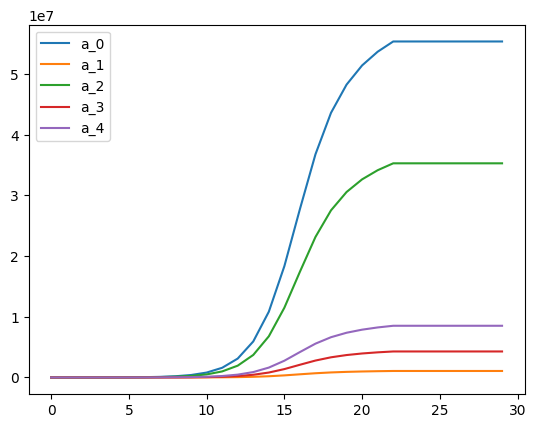

In [10]:
df = pd.DataFrame.from_dict(ret_pcr['ncycle2ret'], orient='index')
df['cycle'] = df.index

cols_efficiencies = df.columns[df.columns.str.contains('efficiencies')]
cols_efficiences = [col for col in cols_efficiencies if col != 'efficiencies_all']

efficiencies_all = np.array([1.]*num_unique_amplicons)
df['efficiencies_all'] = [efficiencies_all]*df.shape[0]

# estimate the overall efficiency constant
for col in cols_efficiences:
    df['efficiencies_all'] = np.multiply(df['efficiencies_all'], df[col])


# calculate cycles that are in the linear range, using gradients
cols_num_amplicon = []
cols_num_amplicon_gradient1 = []
cols_num_amplicon_gradient2 = []
num_unique_amplicons = df['nums_template_at_start_of_cycle'].apply(len)[0]
for i in range(num_unique_amplicons):
    colname = 'a_{}'.format(i)
    cols_num_amplicon.append(colname)
    df[colname] = df['nums_template_at_start_of_cycle'].apply(lambda x: x[i])
    df['{}_gradient1'.format(colname)] = np.gradient(df[colname])
    df['{}_gradient2'.format(colname)] = np.gradient(df['{}_gradient1'.format(colname)])
    cols_num_amplicon_gradient1.append('{}_gradient1'.format(colname))
    cols_num_amplicon_gradient2.append('{}_gradient2'.format(colname))
ncycle_mid = df[cols_num_amplicon_gradient1][df[cols_num_amplicon_gradient1] == df[cols_num_amplicon_gradient1].max()].dropna().index[0]
ncycle_low = df[cols_num_amplicon_gradient2][df[cols_num_amplicon_gradient2] == df[cols_num_amplicon_gradient2].max()].dropna().index[0]
ncycle_high = df[cols_num_amplicon_gradient2][df[cols_num_amplicon_gradient2] == df[cols_num_amplicon_gradient2].min()].dropna().index[0]
print(ncycle_low, ncycle_mid, ncycle_high)

# plot
df[cols_num_amplicon].plot()

### divide by length

In [11]:
# relative quantification of amplicons within a droplet
dflinear = df[['cycle', 'efficiencies_all'] + cols_num_amplicon][ncycle_low:ncycle_high+1]
cols_num_amplicon_0est = ['{}_0est'.format(col) for col in cols_num_amplicon]

# calculate base_constant for each
nums_amplicon_cycle0 = df.loc[0 , cols_num_amplicon].to_numpy()

# n_template_i * (kbase)**ncycle
nums_amplicon_cyclemid = dflinear.loc[ncycle_mid:ncycle_mid+1, cols_num_amplicon].iloc[0].to_numpy()
kbases = (nums_amplicon_cyclemid/nums_amplicon_cycle0)**(1/ncycle_mid)
ampliconid2kbase = {k:v for k, v in zip(cols_num_amplicon, kbases)}
print(ampliconid2kbase)

# ceef * n_template_i * 2**ncycle
coefs = 1/ ((nums_amplicon_cyclemid/nums_amplicon_cycle0)/(2**ncycle_mid))
ampliconid2coef = {k:v for k, v in zip(cols_num_amplicon, coefs)}


cols_num_amplicon_0est = []
for ampliconid in cols_num_amplicon:
    #dflinear['{}_0est'.format(ampliconid)] = dflinear[ampliconid].apply(lambda x: x/(ampliconid2kbase[ampliconid])**ncycle_mid)
    dflinear['{}_0est'.format(ampliconid)] = dflinear[ampliconid].apply(lambda x: (ampliconid2coef[ampliconid])*x/(2**ncycle_mid))
    cols_num_amplicon_0est.append('{}_0est'.format(ampliconid))

cols_num_amplicon_0est_ratio = ['{}_ratio'.format(col) for col in cols_num_amplicon_0est]
dflinear[cols_num_amplicon_0est_ratio] = dflinear[cols_num_amplicon_0est].apply(lambda x: x/x[0], axis=1)

dflinear

{'a_0': 1.922075019852388, 'a_1': 1.9229487589604382, 'a_2': 1.9226297874115363, 'a_3': 1.9229457455617143, 'a_4': 1.9228627915943588}


,cycle,efficiencies_all,a_0,a_1,a_2,a_3,a_4,a_0_0est,a_1_0est,a_2_0est,a_3_0est,a_4_0est,a_0_0est_ratio,a_1_0est_ratio,a_2_0est_ratio,a_3_0est_ratio,a_4_0est_ratio
14,14,"[0.6926010035207669, 0.6958635453471437, 0.694...",1.084205e+07,203738.874188,6.785820e+06,8.149453e+05,1.629585e+06,312.454017,5.828952,194.657726,23.316102,46.655645,1.0,0.018655,0.622996,0.074623,0.149320
15,15,"[0.5126877151055739, 0.5174341007964258, 0.515...",1.835127e+07,345513.329506,1.149974e+07,1.382025e+06,2.763040e+06,528.859983,9.885108,329.881081,39.540625,79.106914,1.0,0.018691,0.623759,0.074766,0.149580
16,16,"[0.32548511664433416, 0.3311898534007621, 0.32...",2.775974e+07,524293.708472,1.743013e+07,2.097122e+06,4.191350e+06,800.000000,15.000000,500.000000,60.000000,120.000000,1.0,0.018750,0.625000,0.075000,0.150000
17,17,"[0.18584563645164767, 0.1915194467020514, 0.18...",3.679512e+07,697934.464919,2.316630e+07,2.791701e+06,5.576580e+06,1060.388093,19.967848,664.547538,79.872350,159.659663,1.0,0.018831,0.626702,0.075324,0.150567
18,18,"[0.106456207284165, 0.1114767237301616, 0.1096...",4.363333e+07,831602.487475,2.755454e+07,3.326521e+06,6.639932e+06,1257.456593,23.792079,790.428470,95.173874,190.103855,1.0,0.018921,0.628593,0.075688,0.151181


<P>1, 	2.601869e+07
<P>2,  4.205690e+07
<P>3, 	5.265162e+07

In [12]:
df

,nums_template_at_start_of_cycle,counter_dnTP_at_start_of_cycle,counter_dnTP_initial,amplicons,efficiencies_dntp_curr,efficiencies_access_curr,efficiencies_denature_curr,efficiencies_anneal_curr,efficiencies_dntp_denature_curr,efficiencies_k_curr,...,a_1_gradient2,a_2,a_2_gradient1,a_2_gradient2,a_3,a_3_gradient1,a_3_gradient2,a_4,a_4_gradient1,a_4_gradient2
0,"[800, 15, 500, 60, 120]","{'A': 5045096845.466576, 'T': 5045096845.46657...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,7.499633,5.000000e+02,5.000000e+02,2.499877e+02,6.000000e+01,60.000000,29.998532,1.200000e+02,1.200000e+02,59.997061
1,"[1600.0, 30.0, 1000.0, 120.0, 240.0]","{'A': 5045041340.466576, 'T': 5045034730.46657...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9999752415449892, 0.9999755310221289, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,14.998532,1.000000e+03,7.499877e+02,4.999509e+02,1.200000e+02,89.998532,59.994127,2.400000e+02,1.799971e+02,119.988243
2,"[3199.960386471983, 59.99926593066387, 1999.97...","{'A': 5044930333.200322, 'T': 5044910503.52628...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9999257267821915, 0.9999265951777222, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,33.742293,1.999975e+03,1.499902e+03,1.124742e+03,2.399971e+02,179.988254,134.969170,4.799941e+02,3.599765e+02,269.938281
3,"[6399.683101589203, 119.9941276258753, 3999.80...","{'A': 5044708332.335874, 'T': 5044662064.94350...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9998267070642238, 0.9998287331386688, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,67.464774,3.999803e+03,2.999472e+03,2.248821e+03,4.799765e+02,359.936872,269.859086,9.599530e+02,7.198736e+02,539.717902
4,"[12798.257183305694, 239.96770423413392, 7998....","{'A': 5044264390.739148, 'T': 5044165255.08008...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.999628709289837, 0.9996330500621335, 0.9996...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,134.848692,7.998919e+03,5.997543e+03,4.494935e+03,9.598708e+02,719.706427,539.394721,1.919741e+03,1.439412e+03,1078.788281
5,"[25591.76249261295, 479.84735233410913, 15994....","{'A': 5043376758.940992, 'T': 5043171916.72412...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9992328851956253, 0.9992418526676715, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,269.371002,1.599489e+04,1.198934e+04,8.978943e+03,1.919389e+03,1438.726313,1077.483816,3.838778e+03,2.877450e+03,2154.962808
6,"[51163.89316534778, 959.3309096781213, 31977.6...","{'A': 5041602522.219493, 'T': 5041186389.32833...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9984419320037939, 0.9984601419874034, 0.998...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,537.432693,3.197760e+04,2.395543e+04,1.791405e+04,3.837323e+03,2874.674058,2149.729985,7.674642e+03,5.749338e+03,4299.440292
7,"[102248.06950619332,

In [13]:
# relative quantification of amplicons within a droplet
dflinear = df[['cycle', 'efficiencies_all'] + cols_num_amplicon][ncycle_low:ncycle_high+1]
cols_num_amplicon_0est = ['{}_0est'.format(col) for col in cols_num_amplicon]

# calculate base_constant for each
nums_amplicon_cycle0 = df.loc[0 , cols_num_amplicon].to_numpy()

# n_template_i * (kbase)**ncycle
nums_amplicon_cyclemid = dflinear.loc[ncycle_mid:ncycle_mid+1, cols_num_amplicon].iloc[0].to_numpy()
kbases = (nums_amplicon_cyclemid/nums_amplicon_cycle0)**(1/ncycle_mid)
ampliconid2kbase = {k:v for k, v in zip(cols_num_amplicon, kbases)}
print('kbase: ', ampliconid2kbase)

# ceef * n_template_i * 2**ncycle
coefs = 1/ ((nums_amplicon_cyclemid/nums_amplicon_cycle0)/(2**ncycle_mid))
ampliconid2coef = {k:v for k, v in zip(cols_num_amplicon, coefs)}
print('coef: ', ampliconid2coef)


cols_num_amplicon_0est = []
for ampliconid in cols_num_amplicon:
    dflinear['{}_0est'.format(ampliconid)] = dflinear[ampliconid].apply(lambda x: x/(ampliconid2kbase[ampliconid])**ncycle_mid)
    #dflinear['{}_0est'.format(ampliconid)] = dflinear[ampliconid].apply(lambda x: (ampliconid2coef[ampliconid])*x/(2**ncycle_mid))
    cols_num_amplicon_0est.append('{}_0est'.format(ampliconid))

cols_num_amplicon_0est_ratio = ['{}_ratio'.format(col) for col in cols_num_amplicon_0est]
dflinear[cols_num_amplicon_0est_ratio] = dflinear[cols_num_amplicon_0est].apply(lambda x: x/x[0], axis=1)

print(ret_pcr['nums_template_at_start_of_cycle'])
dflinear

kbase:  {'a_0': 1.922075019852388, 'a_1': 1.9229487589604382, 'a_2': 1.9226297874115363, 'a_3': 1.9229457455617143, 'a_4': 1.9228627915943588}
coef:  {'a_0': 1.8886634648823937, 'a_1': 1.8749795851367728, 'a_2': 1.87996284198475, 'a_3': 1.875026597404348, 'a_4': 1.8763212606095043}
[800, 15, 500, 60, 120]


,cycle,efficiencies_all,a_0,a_1,a_2,a_3,a_4,a_0_0est,a_1_0est,a_2_0est,a_3_0est,a_4_0est,a_0_0est_ratio,a_1_0est_ratio,a_2_0est_ratio,a_3_0est_ratio,a_4_0est_ratio
14,14,"[0.6926010035207669, 0.6958635453471437, 0.694...",1.084205e+07,203738.874188,6.785820e+06,8.149453e+05,1.629585e+06,312.454017,5.828952,194.657726,23.316102,46.655645,1.0,0.018655,0.622996,0.074623,0.149320
15,15,"[0.5126877151055739, 0.5174341007964258, 0.515...",1.835127e+07,345513.329506,1.149974e+07,1.382025e+06,2.763040e+06,528.859983,9.885108,329.881081,39.540625,79.106914,1.0,0.018691,0.623759,0.074766,0.149580
16,16,"[0.32548511664433416, 0.3311898534007621, 0.32...",2.775974e+07,524293.708472,1.743013e+07,2.097122e+06,4.191350e+06,800.000000,15.000000,500.000000,60.000000,120.000000,1.0,0.018750,0.625000,0.075000,0.150000
17,17,"[0.18584563645164767, 0.1915194467020514, 0.18...",3.679512e+07,697934.464919,2.316630e+07,2.791701e+06,5.576580e+06,1060.388093,19.967848,664.547538,79.872350,159.659663,1.0,0.018831,0.626702,0.075324,0.150567
18,18,"[0.106456207284165, 0.1114767237301616, 0.1096...",4.363333e+07,831602.487475,2.755454e+07,3.326521e+06,6.639932e+06,1257.456593,23.792079,790.428470,95.173874,190.103855,1.0,0.018921,0.628593,0.075688,0.151181


In [14]:
dflinear[['a_0', 'a_1', 'a_2', 'a_3', 'a_4']].apply(lambda x: x/x['a_1'], axis=1)

,a_0,a_1,a_2,a_3,a_4
14,53.215428,1.0,33.306455,3.999950,7.998398
15,53.113051,1.0,33.283062,3.999919,7.996913
16,52.946919,1.0,33.244976,3.999900,7.994280
17,52.720018,1.0,33.192661,3.999948,7.990120
18,52.468974,1.0,33.134274,4.000133,7.984503


<Axes: >

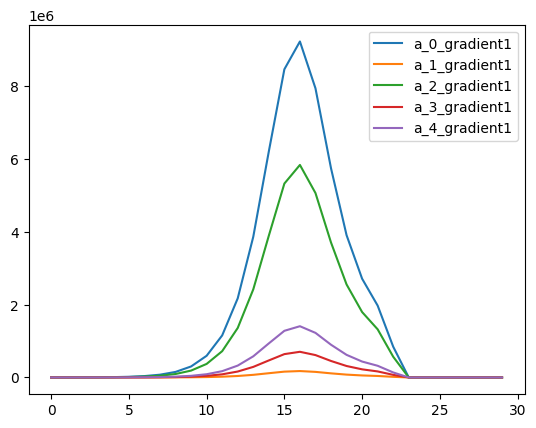

In [15]:
df[cols_num_amplicon_gradient1].plot()

<Axes: >

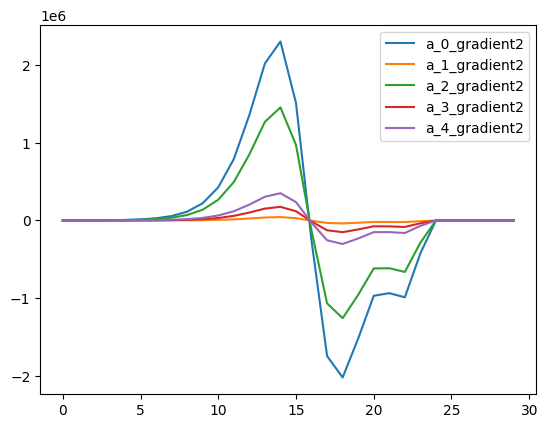

In [16]:
df[cols_num_amplicon_gradient2].plot()

In [17]:
df

,nums_template_at_start_of_cycle,counter_dnTP_at_start_of_cycle,counter_dnTP_initial,amplicons,efficiencies_dntp_curr,efficiencies_access_curr,efficiencies_denature_curr,efficiencies_anneal_curr,efficiencies_dntp_denature_curr,efficiencies_k_curr,...,a_1_gradient2,a_2,a_2_gradient1,a_2_gradient2,a_3,a_3_gradient1,a_3_gradient2,a_4,a_4_gradient1,a_4_gradient2
0,"[800, 15, 500, 60, 120]","{'A': 5045096845.466576, 'T': 5045096845.46657...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,7.499633,5.000000e+02,5.000000e+02,2.499877e+02,6.000000e+01,60.000000,29.998532,1.200000e+02,1.200000e+02,59.997061
1,"[1600.0, 30.0, 1000.0, 120.0, 240.0]","{'A': 5045041340.466576, 'T': 5045034730.46657...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9999752415449892, 0.9999755310221289, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,14.998532,1.000000e+03,7.499877e+02,4.999509e+02,1.200000e+02,89.998532,59.994127,2.400000e+02,1.799971e+02,119.988243
2,"[3199.960386471983, 59.99926593066387, 1999.97...","{'A': 5044930333.200322, 'T': 5044910503.52628...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9999257267821915, 0.9999265951777222, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,33.742293,1.999975e+03,1.499902e+03,1.124742e+03,2.399971e+02,179.988254,134.969170,4.799941e+02,3.599765e+02,269.938281
3,"[6399.683101589203, 119.9941276258753, 3999.80...","{'A': 5044708332.335874, 'T': 5044662064.94350...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9998267070642238, 0.9998287331386688, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,67.464774,3.999803e+03,2.999472e+03,2.248821e+03,4.799765e+02,359.936872,269.859086,9.599530e+02,7.198736e+02,539.717902
4,"[12798.257183305694, 239.96770423413392, 7998....","{'A': 5044264390.739148, 'T': 5044165255.08008...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.999628709289837, 0.9996330500621335, 0.9996...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,134.848692,7.998919e+03,5.997543e+03,4.494935e+03,9.598708e+02,719.706427,539.394721,1.919741e+03,1.439412e+03,1078.788281
5,"[25591.76249261295, 479.84735233410913, 15994....","{'A': 5043376758.940992, 'T': 5043171916.72412...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9992328851956253, 0.9992418526676715, 0.999...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,269.371002,1.599489e+04,1.198934e+04,8.978943e+03,1.919389e+03,1438.726313,1077.483816,3.838778e+03,2.877450e+03,2154.962808
6,"[51163.89316534778, 959.3309096781213, 31977.6...","{'A': 5041602522.219493, 'T': 5041186389.32833...","{'A': 5045096845.466576, 'T': 5045096845.46657...",[GGTGTCATATGGGGCTTAACAAGACCAGAGTAGGTCATGGTGTTG...,"[0.9984419320037939, 0.9984601419874034, 0.998...","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",...,537.432693,3.197760e+04,2.395543e+04,1.791405e+04,3.837323e+03,2874.674058,2149.729985,7.674642e+03,5.749338e+03,4299.440292
7,"[102248.06950619332,

## ddpcr
generate droplets from bulk
sample amplicon template copies in each droplet
single droplet quantification
pool droplets

In [18]:
size_droplet_um = 20
amplicons = [s1, s2, s3, s4, s5]
nums_template_initial=np.array([1000, 5000, 10, 300, 800])*1000
V_i_bulk_ul=200
determine_n_droplets_from_V_i=True
C_i_dna_ng_per_ul = 10
func_droplet_size=None
scale_droplet_size=0.02
num_pcr_cycles = 40

ret_bd = PCR.multiplex_dd_pcr(
      amplicons=amplicons,
      nums_template_amplicon=nums_template_initial,
      V_i_bulk_ul=V_i_bulk_ul,
      n_droplets=10000,
      determine_n_droplets_from_V_i=determine_n_droplets_from_V_i,
      size_droplet_um=size_droplet_um,
      size_type='diameter',
      func_droplet_size=func_droplet_size,
      scale_droplet_size=0,
      num_pcr_cycles=num_pcr_cycles,
      C_i_dna_ng_per_ul=C_i_dna_ng_per_ul,
      C_i_dnTP_mM=0.2,
      C_i_primer_F_uM=0.5,
      C_i_primer_R_uM=0.5,
      C_i_polymerase_U=1, # to be updated
      library_type='dsDNA',
      fragment_size_avg=550,
  )

ret_bd.keys()

dict_keys(['n_droplets', 'Ws_dropid', 'V_total_ul', 'nums_template_amplicon', 'num_droplets_nonempty', 'num_droplets_empty', 'combo2count', 'df_pooled', 'combo2ret_pcr', 'combo2df'])

In [ ]:
# droplets with targets
ret_bd['combo2count']

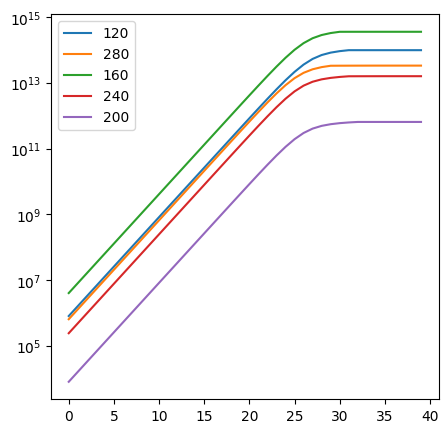

In [25]:
df_pooled = ret_bd['df_pooled']
df = pd.DataFrame.from_dict(df_pooled['all'].to_list())
df.columns = [str(len(col)) for col in df.columns]
df.plot(figsize=(5, 5), )
plt.legend(loc='upper left')
plt.yscale('log')

In [21]:
# determine linear range
cols_length_amplicon = ['120', '160', '200', '240', '280']
cols_num_amplicon_gradient1 = []
cols_num_amplicon_gradient2 = []

df['cycle'] = df.index

for colname in cols_length_amplicon:
    df['{}_gradient1'.format(colname)] = np.gradient(df[colname])
    df['{}_gradient2'.format(colname)] = np.gradient(df['{}_gradient1'.format(colname)])
    cols_num_amplicon_gradient1.append('{}_gradient1'.format(colname))
    cols_num_amplicon_gradient2.append('{}_gradient2'.format(colname))


ncycle_mid = df[cols_num_amplicon_gradient1][df[cols_num_amplicon_gradient1] == df[cols_num_amplicon_gradient1].max()].dropna(how='all').index[0]
ncycle_low = df[cols_num_amplicon_gradient2][df[cols_num_amplicon_gradient2] == df[cols_num_amplicon_gradient2].max()].dropna(how='all').index[0]
ncycle_high = df[cols_num_amplicon_gradient2][df[cols_num_amplicon_gradient2] == df[cols_num_amplicon_gradient2].min()].dropna(how='all').index[0]

print(ncycle_low, ncycle_mid, ncycle_high)


24 26 28


In [22]:
# relative quantification of amplicons within a droplet
dflinear = df.loc[ncycle_low:ncycle_high, :].copy()
cols_num_amplicon_0est = ['{}_0est'.format(col) for col in cols_length_amplicon]

# calculate base_constant for each
nums_amplicon_cycle0 = df.loc[0 , cols_length_amplicon].to_numpy()

# n_template_i * (kbase)**ncycle
nums_amplicon_cyclemid = dflinear.loc[ncycle_mid:ncycle_mid+1, cols_length_amplicon].iloc[0].to_numpy()
kbases = (nums_amplicon_cyclemid/nums_amplicon_cycle0)**(1/ncycle_mid)
ampliconid2kbase = {k:v for k, v in zip(cols_length_amplicon, kbases)}
print('kbase: ', ampliconid2kbase)

# ceef * n_template_i * 2**ncycle
coefs = 1/ ((nums_amplicon_cyclemid/nums_amplicon_cycle0)/(2**ncycle_mid))
ampliconid2coef = {k:v for k, v in zip(cols_length_amplicon, coefs)}
print('coef: ', ampliconid2coef)


cols_length_amplicon_0est = []
for ampliconid in cols_length_amplicon:
    #dflinear['{}_0est'.format(ampliconid)] = dflinear[[ampliconid, 'cycle']].apply(lambda x: x[ampliconid]/(2**x['cycle']), axis=1)
    dflinear['{}_0est'.format(ampliconid)] = dflinear[[ampliconid, 'cycle']].apply(lambda x: x[ampliconid]/(ampliconid2kbase[ampliconid]**x['cycle']), axis=1)
    #dflinear['{}_0est'.format(ampliconid)] = dflinear[ampliconid].apply(lambda x: (ampliconid2coef[ampliconid])*x/(2**ncycle_mid))
    cols_length_amplicon_0est.append('{}_0est'.format(ampliconid))

cols_length_amplicon_0est_ratio = ['{}_ratio'.format(col) for col in cols_length_amplicon_0est]
dflinear[cols_length_amplicon_0est_ratio] = dflinear[cols_length_amplicon_0est].apply(lambda x: x/x[0], axis=1)

print('nums_template_amplicon_initial: {}'.format(ret_bd['nums_template_amplicon']))
dflinear

kbase:  {'120': 1.9691140392318618, '160': 1.961120718400774, '200': 1.955088033204041, '240': 1.9487394574938472, '280': 1.9425449097128964}
coef:  {'120': 1.4987779804593777, '160': 1.6659707162645088, '200': 1.8049103401030409, '240': 1.9641816111962258, '280': 2.1336939119243072}
nums_template_amplicon_initial: [ 799999 3999999    7999  239999  639999]


,120,280,160,240,200,cycle,120_gradient1,120_gradient2,160_gradient1,160_gradient2,...,120_0est,160_0est,200_0est,240_0est,280_0est,120_0est_ratio,160_0est_ratio,200_0est_ratio,240_0est_ratio,280_0est_ratio
24,1.194488e+13,8.459978e+12,5.772858e+13,3.273328e+12,1.123996e+11,24,7.596675e+12,3.796401e+12,3.501868e+13,1.544945e+13,...,1.034382e+06,5.511718e+06,11555.081510,363830.300968,1.014994e+06,1.0,5.328511,0.011171,0.351737,0.981256
25,2.151360e+13,1.385171e+13,1.010808e+14,5.482206e+12,1.926176e+11,25,1.193782e+13,4.162420e+12,5.169997e+13,1.405993e+13,...,9.461093e+05,4.921080e+06,10128.332654,312687.740002,8.555130e+05,1.0,5.201387,0.010705,0.330499,0.904243
26,3.582053e+13,2.012923e+13,1.611285e+14,8.199883e+12,2.974130e+11,26,1.592152e+13,2.593247e+12,6.313855e+13,5.001385e+12,...,7.999990e+05,3.999999e+06,7999.000000,239999.000000,6.399990e+05,1.0,5.000005,0.009999,0.299999,0.800000
27,5.335663e+13,2.579078e+13,2.273579e+14,1.078408e+13,4.043176e+11,27,1.712432e+13,-5.714824e+11,6.170274e+13,-6.683690e+12,...,6.051666e+05,2.878016e+06,5562.013770,161968.757157,4.221295e+05,1.0,4.755742,0.009191,0.267643,0.697543
28,7.006917e+13,3.003564e+13,2.845340e+14,1.275483e+13,4.899832e+11,28,1.477855e+13,-3.091838e+12,4.977117e+13,-1.282879e+13,...,4.035921e+05,1.836593e+06,3447.659318,98303.497643,2.530737e+05,1.0,4.550618,0.008542,0.243571,0.627053


In [23]:
df[28:32][cols_length_amplicon].apply(lambda x: x/x['200'], axis=1)

,120,160,200,240,280
28,143.003192,580.701476,1.0,26.031161,61.299324
29,150.648866,593.956514,1.0,25.667821,60.059700
30,155.160759,601.781676,1.0,25.473459,55.953901
31,158.179999,573.760523,1.0,25.416128,53.420055


In [24]:
df[ncycle_low:ncycle_high+1][cols_length_amplicon].apply(lambda x: x/x['200'], axis=1)

,120,160,200,240,280
24,106.271619,513.601408,1.0,29.122250,75.266996
25,111.690726,524.774557,1.0,28.461608,71.913005
26,120.440369,541.766885,1.0,27.570696,67.681054
27,131.967119,562.325021,1.0,26.672311,63.788425
28,143.003192,580.701476,1.0,26.031161,61.299324


## sigmoid fitting

In [ ]:
from scipy.optimize import curve_fit
ydata = df['120']
xdata = df['cycle']

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# initial guess
#p0 = [max(ydata)-min(ydata), np.median(xdata),1,min(ydata)]
p0 = [ydata.max(), ncycle_mid, 1, min(ydata)]

popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')

In [ ]:
popt

array([8.58771738e+12, 2.68329812e+01, 7.53260303e-01, 8.71945276e+09])

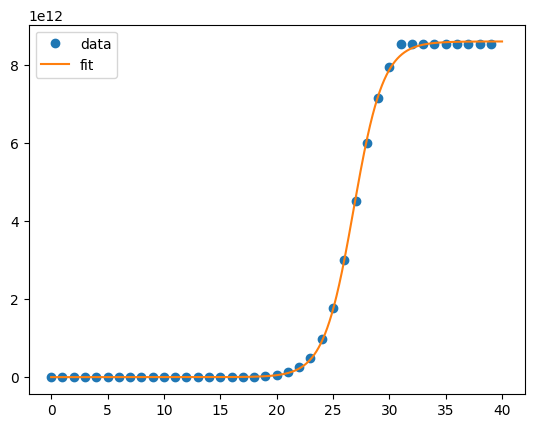

In [ ]:
x = np.linspace(0, 40, 4000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')
#plt.ylim(0, 1.3)
plt.legend(loc='best')

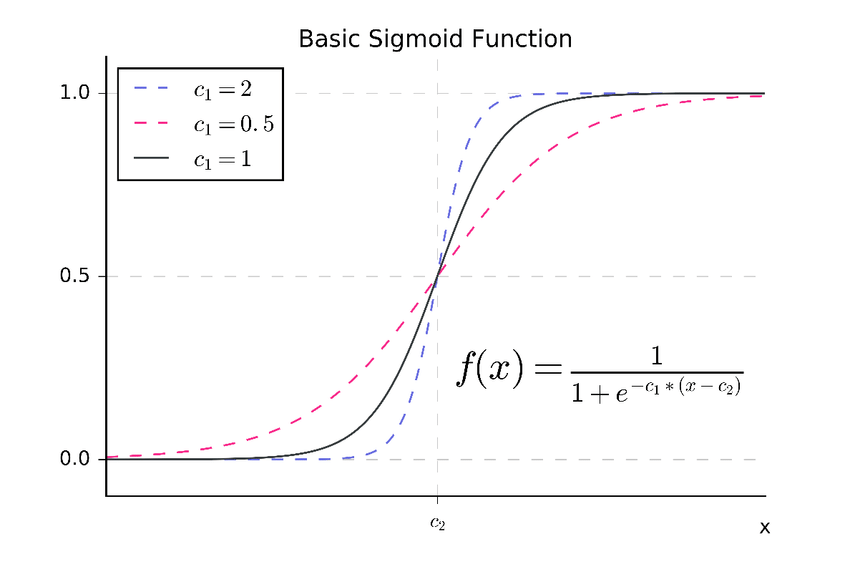

In [ ]:
# USE PCR.multiplex_dd_pcr instead, function copied here for reference.

def multiplex_dd_pcr(
      amplicons,
      nums_template_amplicon,
      V_i_bulk_ul=200,
      n_droplets=10000,
      determine_n_droplets_from_V_i=True,
      efficiency_bulk_to_droplet=0.8,
      size_droplet_um=20,
      size_type='diameter',
      func_droplet_size=None, #np.random.normal,
      scale_droplet_size=0,
      C_i_dna_ng_per_ul=10,
      C_i_dnTP_mM=0.2,
      C_i_primer_F_uM=0.5,
      C_i_primer_R_uM=0.5,
      C_i_polymerase_U=1, # to be updated
      library_type='dsDNA',
      fragment_size_avg=550,
      num_pcr_cycles=40,
      t_denature_intial=95,
      t_denature_cycle=30,
      t_anneal_cycle=62,
      efficiencies_dntp=None,
      efficiencies_dntp_type='square',
      efficiencies_access=None,
      efficiencies_denature=None,
      efficiencies_anneal=None,
      efficiencies_k=None,
  ):

      ret = {}


      # droplet size(s)
      V_droplet_um3 = Droplet.calculate_volume(size=size_droplet_um, size_type=size_type)
      V_droplet_ul = Droplet.convert_um3_to_ul(V_droplet_um3)

      # V_total
      if determine_n_droplets_from_V_i:
          n_droplets = int(V_i_bulk_ul*efficiency_bulk_to_droplet/V_droplet_ul)
      V_total_ul = V_droplet_ul * n_droplets
      ret['n_droplets'] = n_droplets
      ret['Ws_dropid'] = None

      if func_droplet_size:
          sizes_droplet = np.random.normal(size_droplet_um, scale_droplet_size, n_droplets)
          f = lambda x: Droplet.calculate_volume(x)
          Vs_droplet_um3 = f(sizes_droplet)
          f = lambda x: Droplet.convert_um3_to_ul(x)
          Vs_droplet_ul = f(Vs_droplet_um3)
          V_total_ul = sum(Vs_droplet_ul)
          ret['Vs_droplet_ul'] = Vs_droplet_ul
          Ws_dropid = np.array(Vs_droplet_ul) / V_total_ul
          ret['Ws_dropid'] = Ws_dropid
      ret['V_total_ul'] = V_total_ul

      # amplicons
      assert len(amplicons) > 0, 'please provide at least one amplicon sequences'
      num_unique_amplicons = len(amplicons)
      lengths_amplicon = np.array(list(map(len, amplicons)))
      amplicon = np.array(amplicons)

      nums_template_amplicon = np.array(nums_template_amplicon)
      nums_template_amplicon = nums_template_amplicon * V_total_ul / V_i_bulk_ul
      nums_template_amplicon = nums_template_amplicon.astype('int')
      ret['nums_template_amplicon'] = nums_template_amplicon

      # dna
      mass_dna_ng = C_i_dna_ng_per_ul * V_total_ul
      if func_droplet_size:
          masses_dna_ng = mass_dna_ng * Vs_droplet_ul / V_total_ul

      # compartmentalize
      ret_bulk2drop = PCR.compartmentalize_bulk_to_drops(
                          nums_template_amplicon=nums_template_amplicon,
                          n_droplets=n_droplets,
                          V_total_ul=V_total_ul,
                          Ws_dropids=ret['Ws_dropid'],
                      )
      num_droplets_nonempty = len(ret_bulk2drop['dropid_to_aid2count'])
      num_droplets_empty = n_droplets - num_droplets_nonempty
      ret['num_droplets_nonempty'] = num_droplets_nonempty
      ret['num_droplets_empty'] = num_droplets_empty

      if func_droplet_size:
          sizes_droplet_nonemtpy = 'Vs_total_ul'[list(ret_bulk2drop['dropid_to_aid2count'].keys())]
      else:
          sizes_droplet_nonempty = np.array([V_droplet_ul]*len(ret_bulk2drop['dropid_to_aid2count']))

      combos_in_non_empty_droplets =  [tuple(k for k, v in d.items() for i in range(v))
                             for d in ret_bulk2drop['dropid_to_aid2count'].values()]
      combo2count = Counter(combos_in_non_empty_droplets)
      ret['combo2count'] = combo2count

      # run PCR
      combo2ret_pcr = {}
      combo2df = {}
      ls = []
      for k, v in combo2count.items():
          amplicons_droplet = [amplicons[i] for i in k]
          amplicon2count = Counter(amplicons_droplet)
          amplicons_droplet = list(amplicon2count.keys())
          nums_template_initial_droplet = list(amplicon2count.values())
          n_droplets_combo = v

          ret_pcr_droplet = PCR.run_droplet_PCR(
                                amplicons=amplicons_droplet,
                                nums_template_initial=nums_template_initial_droplet,
                                size_droplet_um=size_droplet_um,
                                num_pcr_cycles=num_pcr_cycles,
                                dnTP_mM=C_i_dnTP_mM,
                                dna_ng_per_ul=C_i_dna_ng_per_ul,
                                fragment_size_avg=fragment_size_avg, #bp
                                primer_F_uM = C_i_primer_F_uM,
                                primer_R_uM = C_i_primer_R_uM,
                                t_denature_intial=t_denature_intial,
                                t_denature_cycle=t_denature_cycle,
                                t_anneal_cycle=t_anneal_cycle,
                                efficiencies_dntp=efficiencies_dntp,
                                efficiencies_dntp_type=efficiencies_dntp_type,d
                                efficiencies_access=None,
                                efficiencies_denature=None,
                                efficiencies_anneal=None,
                                efficiencies_k=efficiencies_k,
                                library_type='dsDNA',
                                use_tensor=False,
                            )
          combo2ret_pcr[k] = ret_pcr_droplet

          df_a_droplet = pd.DataFrame.from_dict(ret_pcr_droplet['ncycle2ret'], orient='index')

          dfcombo = df_a_droplet[['amplicons']].copy()
          dfcombo['nums_template_at_start_of_cycle'] = df_a_droplet['nums_template_at_start_of_cycle'].apply(lambda x: np.array(x)*n_droplets_combo)
          dfcombo['{}_amplicon2counter'.format(k)] = dfcombo.apply(lambda x: Counter(dict(zip(x['amplicons'], x['nums_template_at_start_of_cycle']))), axis=1)
          ls.append(dfcombo['{}_amplicon2counter'.format(k)])

          combo2df[k] = dfcombo

      df_pooled = pd.concat(ls, axis=1)
      df_pooled['all'] = df_pooled.apply(lambda x: sum(x, Counter()), axis=1)
      df_pooled['V_total_ul'] = V_total_ul
      ret['df_pooled'] = df_pooled

      ret['combo2ret_pcr'] = combo2ret_pcr
      ret['combo2df'] = combo2df

      # break emulsion

      return ret


whenn the measured flurorescence < Flourescence level > not detectable


# to do: length normalization
qpcr

electrophephoresis,